In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers,datasets
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense,Activation
import math
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
feature_extractor_url = "tf2-preview_mobilenet_v2_feature_vector_4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,input_shape=(224,224,3))
# 这一层的训练值保持不变
feature_extractor_layer.trainable = False

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
epochs = 4
batch_size = 16
train_data_dir = 'd:\\projects\\veg_2019\\train_V_224'
img_width,img_height=224,224

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 4271 images belonging to 9 classes.
Found 470 images belonging to 9 classes.


In [5]:
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=len(train_generator.class_indices))
train_generator.class_indices

{'apple': 0,
 'bean': 1,
 'cabbage': 2,
 'carrot': 3,
 'cauliflower': 4,
 'cucumber': 5,
 'eggplant': 6,
 'mashroom': 7,
 'pitaya': 8}

In [6]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(9, activation='softmax')
])

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
checkpoint_path = "first_round/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# history = model.fit(train_x, train_y, epochs=1, callbacks=[cp_callback])
# loss, acc = model.evaluate(test_x, test_y)
# print(acc)

In [9]:
history = model.fit_generator(
    train_generator,
    epochs=2,
    shuffle=True,
    workers=6,
    validation_data=validation_generator,
    callbacks=[cp_callback]
)

Epoch 1/2
266/267 [============================>.] - ETA: 0s - loss: 0.1783 - acc: 0.9546
Epoch 00001: saving model to first_round/cp.ckpt
267/267 [==============================] - 69s 258ms/step - loss: 0.1777 - acc: 0.9548 - val_loss: 0.0350 - val_acc: 0.9979
Epoch 2/2
266/267 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9995
Epoch 00002: saving model to first_round/cp.ckpt
267/267 [==============================] - 60s 226ms/step - loss: 0.0105 - acc: 0.9995 - val_loss: 0.0183 - val_acc: 0.9979


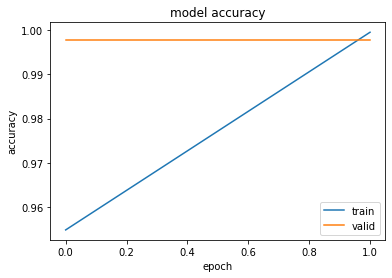

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

In [12]:
# import json
# with open('first_round_history.json', 'w') as f:
#     json.dump(history.history, f)

In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("first_round.tflite", "wb").write(tflite_model)

8916380

# prediction

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers,datasets
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense,Activation
import math
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [2]:
test_data_dir = 'd:\\projects\\veg_2019\\test_V'
test_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    test_data_dir,
    target_size=(224,224),
    classes=['apple','bean','cabbage','carrot','cauliflower','cucumber','eggplant','mashroom','pitaya'],
    #classes=None,
    batch_size=1024,
    shuffle=False
)

Found 518 images belonging to 9 classes.


In [3]:
test_ims, test_labels = next(test_batches)
print(np.argmax(test_labels,axis=1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 

In [4]:
y_true = np.argmax(test_labels,axis=1)

In [5]:
from tensorflow.keras.models import Model

In [6]:
feature_extractor_url = "tf2-preview_mobilenet_v2_feature_vector_4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,input_shape=(224,224,3))
feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(9, activation='softmax')
])

model.load_weights('first_round/cp.ckpt')

In [7]:
predictions = model.predict_generator(test_batches,verbose=1)

1/1 [==============================] - 8s 8s/step


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
y_pred = np.argmax(predictions,axis=1)
class_names = ['apple','bean','cabbage','carrot','cauliflower','cucumber','eggplant','mashroom','pitaya']

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas  as pd
import seaborn as sn

In [11]:
print(classification_report(y_true,y_pred,target_names=class_names))

              precision    recall  f1-score   support

       apple       0.93      0.28      0.43        50
        bean       0.92      0.32      0.48        75
     cabbage       0.96      0.98      0.97        50
      carrot       0.88      0.84      0.86        55
 cauliflower       1.00      0.98      0.99        64
    cucumber       0.86      0.73      0.79       112
    eggplant       0.20      0.97      0.33        35
    mashroom       0.92      0.44      0.60        27
      pitaya       0.85      0.56      0.67        50

    accuracy                           0.68       518
   macro avg       0.84      0.68      0.68       518
weighted avg       0.86      0.68      0.71       518



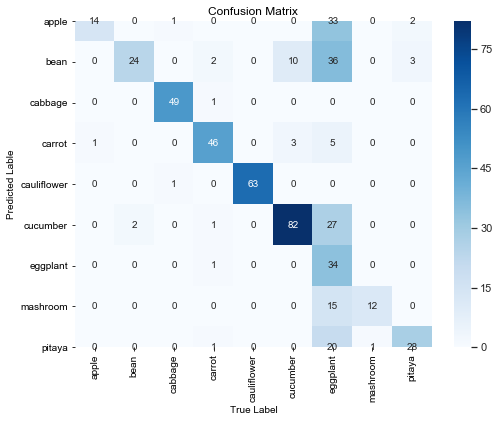

In [12]:
cnf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cnf_matrix, class_names,class_names)
f,ax = plt.subplots(figsize = (8,6))
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},cmap='Blues', fmt='g')# font size
ax.set_title('Confusion Matrix')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Lable')
plt.show()